In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pymulticonsensus
from random import randint
from time import time
from pylsd.lsd import lsd
import sys
sys.path.append('../dataset_comparison/')
from utils import get_soft_assignment, draw_soft_assignment, draw_labeling, model_type, random_color

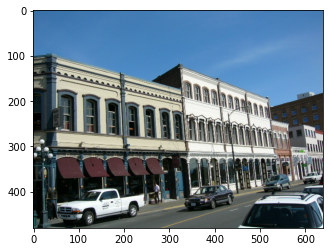

In [21]:
# Load the images
img = cv2.cvtColor(cv2.imread('../build/data/vanishing_point_example.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

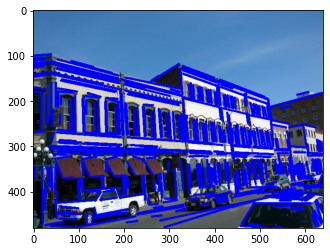

In [22]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
detected_linesegments = lsd(gray, density_th=0.0)
length_threshold = 20
linesegments = []
lengths = []

#Show image
line_img = img.copy()
for i in range(detected_linesegments.shape[0]):
    # Convert the line to its implicit form
    pt1 = np.array([detected_linesegments[i, 0], detected_linesegments[i, 1]])
    pt2 = np.array([detected_linesegments[i, 2], detected_linesegments[i, 3]])
    v = pt2 - pt1
    line_length = np.linalg.norm(v)

    if line_length < length_threshold:
        continue

    lengths.append(line_length)
    linesegments.append(detected_linesegments[i, :])
    
    # Draw the line
    pt1i = (int(detected_linesegments[i, 0]), int(detected_linesegments[i, 1]))
    pt2i = (int(detected_linesegments[i, 2]), int(detected_linesegments[i, 3]))
    width = 6 # detected_linesegments[i, 4]
    cv2.line(line_img, pt1i, pt2i, (0, 0, 255), int(np.ceil(width / 2)))
plt.imshow(line_img)

linesegments = np.array(linesegments)


In [23]:
def get_vanishing_points(img, lines, inlier_threshold = 1.0):    
    vanishing_points = pymulticonsensus.findVanishingPoints(
        np.ascontiguousarray(lines), 
        img.shape[1], img.shape[0], 
        threshold = inlier_threshold,
        confidence = 0.999,
        neighborhood_ball_radius = 20.0,
        maximum_tanimoto_similarity = 0.85,
        starting_hypothesis_number = 10,
        added_hypothesis_number = 10,
        max_iters = 75,
        minimum_point_number = 10,
        sampler_id = 0)  
    return np.array(vanishing_points)

In [24]:
t = time()

inlier_threshold = 3
linesegments[:,4] /= np.sum(linesegments[:,4])
vanishing_points = get_vanishing_points(img, linesegments[:,0:4], inlier_threshold=inlier_threshold)

model_number = int(vanishing_points.size / 3)

print ('Time = ', time()-t, ' sec')
print ('Models found = {}'.format(model_number))

Time =  0.017499446868896484  sec
Models found = 5


Drawing a soft labeling
28
37
64
6
17


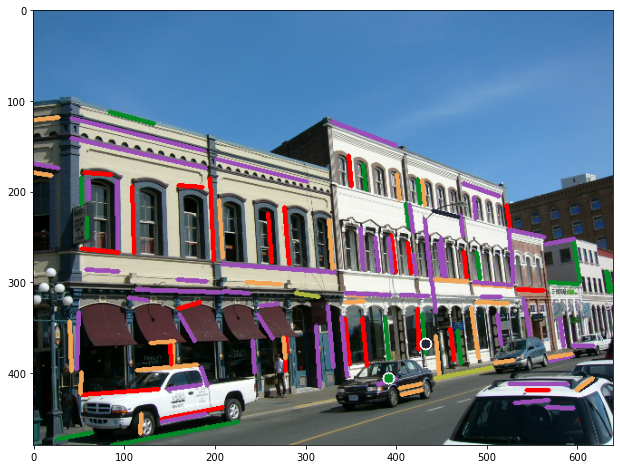

In [25]:
print("Drawing a soft labeling")

soft_assignment = pymulticonsensus.getSoftLabeling(
	vanishing_points,
	linesegments[:,0:4],
	model_type("vanishing_point"),
	inlier_threshold)

point_number = soft_assignment.shape[0]
model_number = soft_assignment.shape[1]
shared_color = (255, 0, 0)
colors = []
for model_idx in range(model_number):
    colors.append(random_color())
    
img_cpy = img.copy()

for point_idx in range(point_number):
    model_indices = soft_assignment[point_idx, :] > 0

    pt1i = (int(linesegments[point_idx, 0]), int(linesegments[point_idx, 1]))
    pt2i = (int(linesegments[point_idx, 2]), int(linesegments[point_idx, 3]))
    width = 6
        
    if np.sum(model_indices) > 1:
        cv2.line(img_cpy, pt1i, pt2i, shared_color, int(np.ceil(width / 2)))
    elif np.sum(model_indices) == 1:
        idx = np.where(model_indices)[0][0]
        cv2.line(img_cpy, pt1i, pt2i, colors[idx], int(np.ceil(width / 2)))
     
for model_idx in range(model_number):
    point_indices = soft_assignment[:, model_idx] > 0
    print(np.sum(point_indices))
    
    vp = vanishing_points[model_idx]
    if abs(vp[2]) < 1e-10:
        continue

    vp /= vp[2]
    vp = (int(vp[0]), int(vp[1]))

    cv2.circle(img_cpy, vp, 7, (255, 255, 255), -1)
    cv2.circle(img_cpy, vp, 5, colors[model_idx], -1)

# Plot the two images side by side using matplotlib.pyplot
plt.figure(figsize = (12,8))
plt.imshow(img_cpy)
plt.show() 


Drawing a hard labeling
Drawing the lines assigned to the 1-th vanishing point.
# inliers = 23
Drawing the lines assigned to the 2-th vanishing point.
# inliers = 36
Drawing the lines assigned to the 3-th vanishing point.
# inliers = 63
Drawing the lines assigned to the 4-th vanishing point.
# inliers = 4
Drawing the lines assigned to the 5-th vanishing point.
# inliers = 7


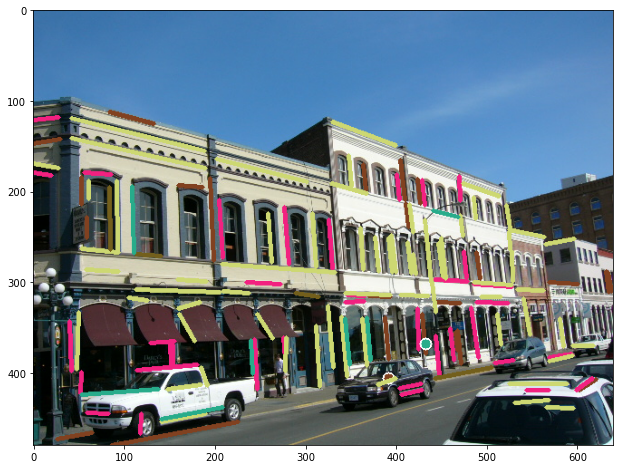

In [28]:
print("Drawing a hard labeling")

labeling = pymulticonsensus.getLabeling(
	vanishing_points,
	linesegments[:,0:4],
	model_type("vanishing_point"),
	inlier_threshold,
    20.0,
    0,
    0)

img_cpy = img.copy()

for idx in range(model_number):    
    mask = np.zeros(len(labeling))
    indices = [i for i, e in enumerate(labeling) if e == idx]
    color = (randint(0, 255), randint(0, 255), randint(0, 255))

    vp = vanishing_points[idx]

    print("Drawing the lines assigned to the {}-th vanishing point.".format(int(idx + 1)))
    print(f"# inliers = {len(indices)}")
    
    for i in indices:
        # Draw the line
        pt1i = (int(linesegments[i, 0]), int(linesegments[i, 1]))
        pt2i = (int(linesegments[i, 2]), int(linesegments[i, 3]))
        width = 6 #linesegments[i, 4]
        
        cv2.line(img_cpy, pt1i, pt2i, color, int(np.ceil(width / 2)))
    
    if abs(vp[2]) < 1e-10:
        continue

    vp /= vp[2]
    vp = (int(vp[0]), int(vp[1]))

    cv2.circle(img_cpy, vp, 7, (255, 255, 255), -1)
    cv2.circle(img_cpy, vp, 5, color, -1)
    break
    
plt.figure(figsize = (12,8))
plt.imshow(img_cpy)